In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from keras.layers import BatchNormalization, Dense, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout
from keras.models import Sequential, Model
from keras import backend as K
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt


In [2]:
epochs = 20
batch_size = 16

In [3]:
# Hàm chuyển đổi một tệp JSON thành định dạng đầu ra phù hợp
def process_json(json_data, folder_name, dataset_path):
    # Trích xuất thông tin từ tệp JSON
    image_path = os.path.join(dataset_path, folder_name, json_data["imagePath"])
    annotations = []
    
    for shape in json_data["shapes"]:
        x1, y1 = shape["points"][0]
        x2, y2 = shape["points"][1]

        # Sắp xếp tọa độ để x1 < x2 và y1 < y2
        x_min = min(x1, x2)
        x_max = max(x1, x2)
        y_min = min(y1, y2)
        y_max = max(y1, y2)

        width = x_max - x_min
        height = y_max - y_min

        annotations.append({
            "Label": shape["label"],
            "Bbox": [x_min, y_min, width, height]
        })

    return {
        "image_path": image_path,
        "annotations": annotations
    }

# Chuyển đổi dữ liệu hình ảnh và nhãn thành NumPy arrays và điều chỉnh kích thước ảnh
def load_and_resize_images(data):
    images = []
    bboxes = []
    labels = []

    for item in data:
        image = cv2.imread(item['image_path'])

        annotation = item["annotations"]
        bbox_list = []
        label_list = []
        image_list = []

        for ann in annotation:
            # Thay đổi nhãn "Airplane" thành 1 và "Helicopter" thành 0
            label = 1 if ann['Label'] == 'Airplane' else 0
            bbox_list.append(ann['Bbox'])
            label_list.append(label)
            image_list.append(image)

        images.extend(image_list)
        bboxes.extend(bbox_list)
        labels.extend(label_list)  # Sử dụng extend() để thêm các giá trị của label_list vào labels

    images = np.array(images)
    bboxes = np.array(bboxes)
    labels = np.array(labels)

    return images, [bboxes, labels]

In [4]:
dataset_path = "Data"
# Tạo danh sách để lưu trữ dữ liệu định dạng đầu ra
formatted_data = []

for folder_name in os.listdir(dataset_path):
    json_folder = os.path.join(dataset_path, folder_name)

    # Xử lý dữ liệu từ các tệp JSON trong thư mục
    for filename in os.listdir(json_folder):
        if filename.endswith('.json'):
            file_path = os.path.join(json_folder, filename)
            with open(file_path, 'r') as json_file:
                json_data = json.load(json_file)
                formatted_data.append(process_json(json_data, folder_name, dataset_path))

from sklearn.model_selection import train_test_split

# Dữ liệu đã được chuẩn hóa và lưu trong biến formatted_data

# Tách dữ liệu thành tập huấn luyện (60%), tập xác thực (20%) và tập kiểm tra (20%)
train_data, temp_data = train_test_split(formatted_data, test_size=0.4, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# In số lượng mẫu trong mỗi tập
print(f"Số lượng mẫu trong tập huấn luyện: {len(train_data)}")
print(f"Số lượng mẫu trong tập xác thực: {len(validation_data)}")
print(f"Số lượng mẫu trong tập kiểm tra: {len(test_data)}")

# Chia dữ liệu thành các biến
# Chia dữ liệu thành các biến
x_train, y_train = load_and_resize_images(train_data)
x_validation, y_validation = load_and_resize_images(validation_data)
x_test, y_test = load_and_resize_images(test_data)


Số lượng mẫu trong tập huấn luyện: 300
Số lượng mẫu trong tập xác thực: 100
Số lượng mẫu trong tập kiểm tra: 100


In [5]:
# Hàm tính IoU (Intersection over Union)
def iou(y_true, y_pred):
    intersection = K.sum(K.minimum(y_true, y_pred))
    union = K.sum(K.maximum(y_true, y_pred))
    return intersection / union


In [5]:
# Xây dựng mô hình
model = Sequential()

model.add(SeparableConv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.5))

model.add(SeparableConv2D(64, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.5))

model.add(SeparableConv2D(128, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2))) 
#model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# Đầu ra cho bounding box (4 giá trị: x, y, width, height)
bbox_output = Dense(4, activation='linear', name='BBox')(model.layers[-1].output)

# Đầu ra cho label (1 giá trị xác suất)
label_output = Dense(1, activation='sigmoid', name='Label')(model.layers[-1].output)

# Tạo mô hình
model = Model(inputs=model.inputs, outputs=[bbox_output, label_output])

# Kết hợp hàm mất mát
model.compile(optimizer='adam',
              loss={'Label': 'binary_crossentropy', 'BBox': 'mean_squared_error'},
              metrics={"Label":'accuracy', "BBox": iou})

# Kiểm tra mô hình
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 separable_conv2d_input (InputL  [(None, 224, 224, 3  0          []                               
 ayer)                          )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 222, 222, 32  155        ['separable_conv2d_input[0][0]'] 
 v2D)                           )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 111, 111, 32  0           ['separable_conv2d[0][0]']       
                                )                                                             

In [6]:

# Huấn luyện mô hình với nhãn đã được mã hóa
history = model.fit(
    x_train,
    {'BBox': y_train[0], 'Label': y_train[1]},
    validation_data=(x_validation, {'BBox': y_validation[0], 'Label': y_validation[1]}),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/20
19/19 [==============================] - 15s 640ms/step - loss: 4052.1001 - BBox_loss: 4044.0889 - Label_loss: 8.0108 - BBox_iou: 0.5947 - Label_accuracy: 0.5167 - val_loss: 2558.6638 - val_BBox_loss: 2555.2876 - val_Label_loss: 3.3762 - val_BBox_iou: 0.6927 - val_Label_accuracy: 0.4257
Epoch 2/20
19/19 [==============================] - 11s 606ms/step - loss: 2081.8132 - BBox_loss: 2078.1721 - Label_loss: 3.6410 - BBox_iou: 0.6948 - Label_accuracy: 0.4133 - val_loss: 1931.2402 - val_BBox_loss: 1928.6134 - val_Label_loss: 2.6269 - val_BBox_iou: 0.6997 - val_Label_accuracy: 0.3564
Epoch 3/20
19/19 [==============================] - 12s 623ms/step - loss: 1342.9232 - BBox_loss: 1338.0098 - Label_loss: 4.9134 - BBox_iou: 0.7525 - Label_accuracy: 0.3733 - val_loss: 1888.4611 - val_BBox_loss: 1884.3812 - val_Label_loss: 4.0798 - val_BBox_iou: 0.7452 - val_Label_accuracy: 0.2970
Epoch 4/20
19/19 [==============================] - 12s 621ms/step - loss: 1099.3430 - BBox_loss: 1094.

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn import metrics

def IoU(bbox_true, bbox_pred):
    x1_t, y1_t, w1_t, h1_t = bbox_true
    x1_p, y1_p, w1_p, h1_p = bbox_pred

    x2_t = x1_t + w1_t
    y2_t = y1_t + h1_t
    x2_p = x1_p + w1_p
    y2_p = y1_p + h1_p

    xA = max(x1_t, x1_p)
    yA = max(y1_t, y1_p)
    xB = min(x2_t, x2_p)
    yB = min(y2_t, y2_p)

    inter_area = max(0, xB - xA) * max(0, yB - yA)

    box1_area = w1_t * h1_t
    box2_area = w1_p * h1_p

    iou = inter_area / float(box1_area + box2_area - inter_area)

    return iou

def evaluate_model(result_pred, data_test_combined):
    data_test_bbox, data_test_labels =data_test_combined[0], data_test_combined[1]
    # Trích xuất bounding box và label từ đầu ra
    bbox_pred, label_pred = result_pred[0], result_pred[1]

    # Đánh giá mô hình label
    # Convert label predictions to binary using a threshold
    label_pred = [1 if val >= 0.5 else 0 for val in label_pred]
    label_accuracy = accuracy_score(data_test_labels, label_pred)
    label_precision = precision_score(data_test_labels, label_pred)
    label_recall = recall_score(data_test_labels, label_pred)
    label_f1 = f1_score(data_test_labels, label_pred)

    class_report= classification_report(data_test_labels, label_pred, target_names=["Airplane", "Helicopter"])

    # Đánh giá mô hình bounding box sử dụng IoU
    iou_scores = []
    for i in range(len(data_test_combined)):
        IoU = iou(data_test_bbox[i][:4], bbox_pred[i][:4])
        iou_scores.append(IoU.numpy())

    average_iou = sum(iou_scores) / len(iou_scores)

    results = {
        "Label Accuracy": label_accuracy,
        "Label Precision": label_precision,
        "Label Recall": label_recall,
        "Label F1-score": label_f1,
        "Average IoU": average_iou,
    }

    # Sử dụng ConfusionMatrixDisplay cho label
    print("Label Confusion Matrix: ")
    label_conf_matrix = confusion_matrix(data_test_labels, label_pred)
    label_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=label_conf_matrix, display_labels=["Airplane", "Helicopter"])
    label_cm_display.plot()
    plt.show()

    print("Label Classification Report:", class_report)
    print("Evaluation indicators:")
    return results

In [7]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_bboxes(image, actual_bbox, predicted_bbox, actual_class, predicted_class):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image, cmap='gray')

    # Vẽ bounding box thực tế (màu xanh lá cây) và gắn tên object
    if actual_bbox is not None:
        actual_rect = patches.Rectangle(
            (actual_bbox[0], actual_bbox[1]), actual_bbox[2], actual_bbox[3],
            linewidth=3, edgecolor='lime', facecolor='none', label='Actual'
        )
        ax.add_patch(actual_rect)
        ax.text(actual_bbox[0], actual_bbox[1], actual_class, color='lime', backgroundcolor='none', fontsize=16)

    # Vẽ bounding box dự đoán (màu đỏ) và gắn tên object
    if predicted_bbox is not None:
        x, y, width, height = predicted_bbox
        # Đảm bảo rằng bbox không vượt qua kích thước ảnh 224x224
        x = max(0, x)
        y = max(0, y)
        x_max = min(x + width, 224)
        y_max = min(y + height, 224)
        width = x_max - x
        height = y_max - y

        predicted_rect = patches.Rectangle(
            (x, y), width, height,
            linewidth=3, edgecolor='black', facecolor='none', label='Predicted'
        )
        ax.add_patch(predicted_rect)
        ax.text(x, y+height, predicted_class, color='black', backgroundcolor='none', fontsize=16)
    print("Actual_bbox:", actual_bbox)
    print("Predicted_bbox:", predicted_bbox)
    # Hiển thị
    plt.legend(handles=[actual_rect, predicted_rect])
    plt.axis('on')
    plt.show()

In [ ]:
# Lưu model vào đường dẫn được chỉ định
model.save('Localization_Airplane_or_Helicopter(Update).keras')

In [9]:
from tensorflow import keras

# Đăng ký hàm 'iou' trong tùy chỉnh các đối tượng của Keras
keras.utils.get_custom_objects()['iou'] = iou
# Tải mô hình từ file
loaded_model = keras.models.load_model('Localization_Airplane_or_Helicopter(Update).keras')

In [10]:
# Đánh giá mô hình trên tập kiểm tra
test_scores = loaded_model.evaluate(
    x_test,
    {'BBox': np.array(y_test[0]), 'Label': np.array(y_test[1])},
    verbose=1
)

# In kết quả đánh giá
print("x_test Losses:")
print("Bounding Box Loss:", test_scores[1])
print("Label Loss:", test_scores[2])
print("Bouding Box IoU:", test_scores[3])
print("Label Accuracy:", test_scores[4])

4/4 [==============================] - 1s 214ms/step - loss: 845.6777 - BBox_loss: 845.4422 - Label_loss: 0.2355 - BBox_iou: 0.7834 - Label_accuracy: 0.9200
x_test Losses:
Bounding Box Loss: 845.4421997070312
Label Loss: 0.23553815484046936
Bouding Box IoU: 0.7833612561225891
Label Accuracy: 0.9200000166893005


4/4 [==============================] - 1s 198ms/step
Label Confusion Matrix: 


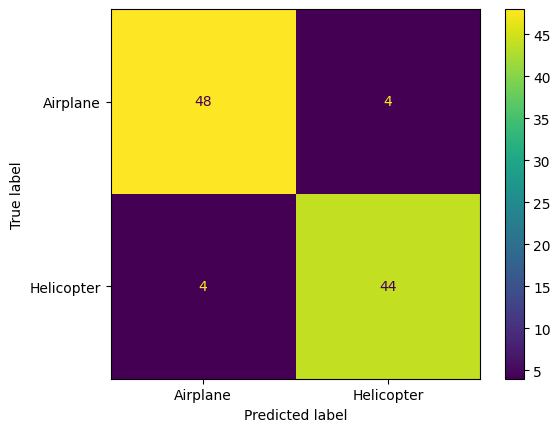

Label Classification Report:               precision    recall  f1-score   support

    Airplane       0.92      0.92      0.92        52
  Helicopter       0.92      0.92      0.92        48

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100

Evaluation indicators:


{'Label Accuracy': 0.92,
 'Label Precision': 0.9166666666666666,
 'Label Recall': 0.9166666666666666,
 'Label F1-score': 0.9166666666666666,
 'Average IoU': 0.8562260404647802}

In [11]:
# Sử dụng mô hình đã tải
result_pred = loaded_model.predict(x_test)
evaluate_model(result_pred, y_test)

IoU of random image: 0.851540195899468
Actual_bbox: [  0.30845771  72.94527363 221.69154229  99.05472637]
Predicted_bbox: [ 14.163156  70.78967  196.55342   99.12805 ]


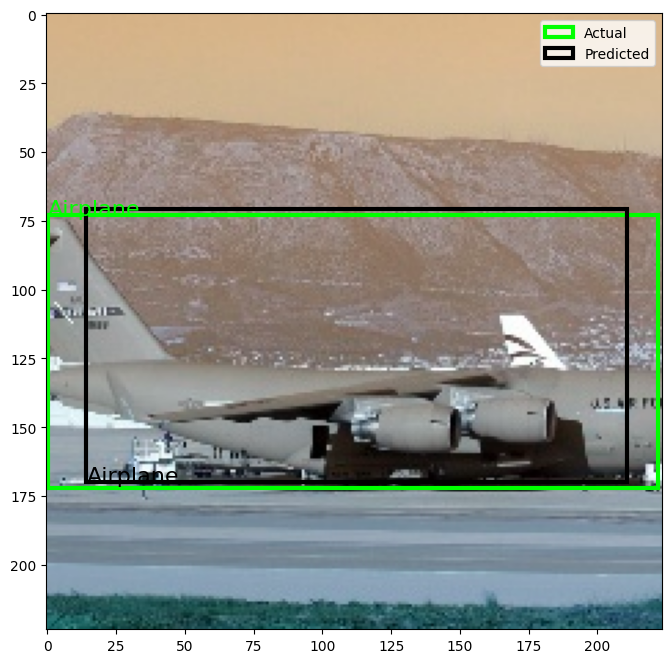

In [35]:
# Chọn một chỉ số ngẫu nhiên từ data_test
random_index = random.randint(0, len(x_test) - 1)
image = x_test[random_index]
actual_bbox = y_test[0][random_index][:4]
predicted_bbox = result_pred[0][random_index][:4]
actual_class = "Helicopter" if y_test[1][random_index] == 0 else "Airplane"
predicted_class = "Helicopter" if result_pred[1][random_index] < 0.5 else "Airplane"

# Gọi hàm để vẽ bounding box thực tế và dự đoán trên cùng một bức ảnh và hiển thị tên object
print("IoU of random image:", IoU(actual_bbox,predicted_bbox))
plot_image_with_bboxes(image, actual_bbox, predicted_bbox, actual_class, predicted_class)

In [36]:
data_test_path = "Test"
# Tạo danh sách để lưu trữ dữ liệu định dạng đầu ra
list_data_test = []

for folder_name in os.listdir(data_test_path):
    json_folder = os.path.join(data_test_path, folder_name)

    # Xử lý dữ liệu từ các tệp JSON trong thư mục
    for filename in os.listdir(json_folder):
        if filename.endswith('.json'):
            file_path = os.path.join(json_folder, filename)
            with open(file_path, 'r') as json_file:
                json_data = json.load(json_file)
                list_data_test.append(process_json(json_data, folder_name, data_test_path))

data_test, data_test_combined = load_and_resize_images(list_data_test)


In [37]:
# Đánh giá mô hình trên tập kiểm tra
test_scores = loaded_model.evaluate(
    data_test,
    {'BBox': np.array(data_test_combined[0]), 'Label': np.array(data_test_combined[1])},
    verbose=1
)

# In kết quả đánh giá
print("Data_Test Losses:")
print("Bounding Box Loss:", test_scores[1])
print("Label Loss:", test_scores[2])
print("BBox IoU:", test_scores[3])
print("Label Accuracy:", test_scores[4])

4/4 [==============================] - 1s 182ms/step - loss: 587.8479 - BBox_loss: 587.5986 - Label_loss: 0.2493 - BBox_iou: 0.8341 - Label_accuracy: 0.9600
Data_Test Losses:
Bounding Box Loss: 587.5985717773438
Label Loss: 0.24932001531124115
BBox IoU: 0.8341444134712219
Label Accuracy: 0.9599999785423279


4/4 [==============================] - 1s 184ms/step
Label Confusion Matrix: 


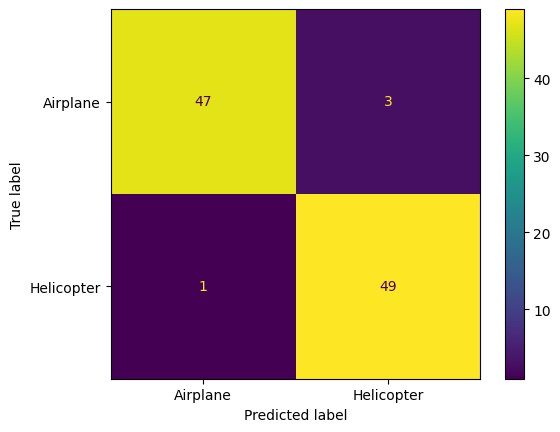

Label Classification Report:               precision    recall  f1-score   support

    Airplane       0.98      0.94      0.96        50
  Helicopter       0.94      0.98      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100

Evaluation indicators:


{'Label Accuracy': 0.96,
 'Label Precision': 0.9423076923076923,
 'Label Recall': 0.98,
 'Label F1-score': 0.9607843137254902,
 'Average IoU': 0.8309628278593351}

In [38]:
# Sử dụng mô hình đã tải
result_pred = loaded_model.predict(data_test)
evaluate_model(result_pred, data_test_combined)

IoU of random image: 0.9671314452937477
Actual_bbox: [  1.80099502  93.84079602 221.19900498  63.15920398]
Predicted_bbox: [  2.5937247  93.56508   222.04471    64.59834  ]


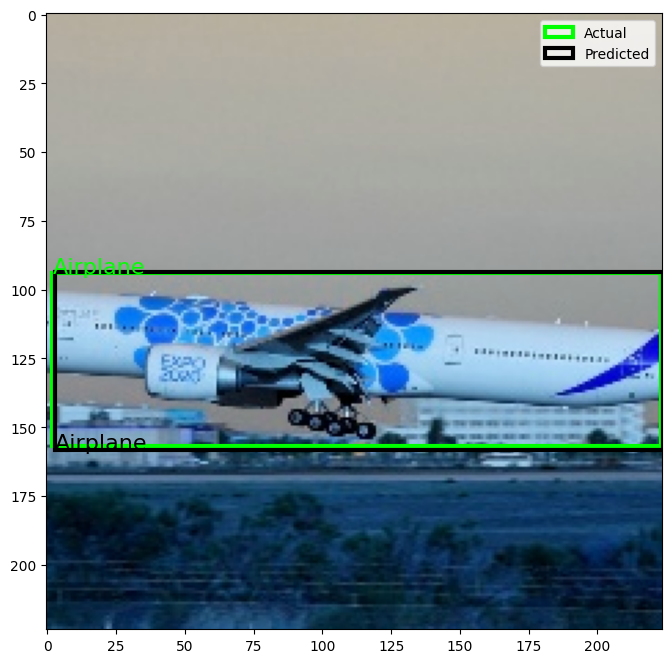

In [43]:
# Chọn một chỉ số ngẫu nhiên từ data_test
random_index = random.randint(0, len(data_test) - 1)
image = data_test[random_index]
actual_bbox = data_test_combined[0][random_index][:4]
predicted_bbox = result_pred[0][random_index][:4]
actual_class = "Helicopter" if data_test_combined[1][random_index] == 0 else "Airplane"
predicted_class = "Helicopter" if result_pred[1][random_index] < 0.5 else "Airplane"

# Gọi hàm để vẽ bounding box thực tế và dự đoán trên cùng một bức ảnh và hiển thị tên object
print("IoU of random image:", IoU(actual_bbox,predicted_bbox))
plot_image_with_bboxes(image, actual_bbox, predicted_bbox, actual_class, predicted_class)
